# From Detection to Credibility: A Machine Learning Framework for Assessing News Source Reliability



In [2]:
# !pip3 install -r requirements.txt
# !pip3 install tensorflow
# !pip3 install gensim
!pip3 install scipy==1.10.1

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions:

In [12]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

# Count Vectoriser + Neural network


We first experiment with the use of a neural network for the classification task at hand.

We use a neural network for the following reasons:
#### Handling High-Dimensional Data: 
Neural networks are suited for handling high-dimensional data because they can learn complex patterns and relationships between features, such as text embeddings. This allows for the modelling of complex patterns between words or phrases.

#### Adaptability to Textual Nuances:
Neural networks can capture contextual information and nuances in text better than traditional models, which is crucial for accurately classifying fake news.

#### Enhanced Performance with Non-Linearities:
Neural networks can leverage non-linear fucntions (e.g., ReLU, sigmoid) to capture more intricate patterns in the data, allowing them to be able to discern subtle cues in language taht indicate misleading content.

Building upon our experiment using CNN, 

We use only 2 hidden layers with a dropout rate of 0.3 initially.
Additionally, the ADAM (Adaptive Moment Estimation) optimiser is used to adjust the weights to minimise the loss function (binary crossentropy for binary classification tasks).
Early stopping and L2 regularizer is implemented to prevent the tree from being overfitted.
Lastly, we set the number of epochs to 20, and allocate a batch size of 64.

In [13]:

# !pip install scikit-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

import tensorflow as tf
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

data = pd.read_csv('processed_data.csv')

use = data['processed_full_content'].apply(lambda x: x.lower())
vectorizer = CountVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(use).toarray()


X_train, X_test, y_train, y_test = train_test_split(X_vectorized, data['label'],test_size=0.2, random_state=42)

model = Sequential()

# Input layer and first hidden layer with dropout
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

# Second hidden layer with dropout
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=20, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8926 - loss: 1.0148 - val_accuracy: 0.9402 - val_loss: 0.3671
Epoch 2/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9391 - loss: 0.3621 - val_accuracy: 0.9439 - val_loss: 0.3375
Epoch 3/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9411 - loss: 0.3419 - val_accuracy: 0.9450 - val_loss: 0.3359
Epoch 4/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9426 - loss: 0.3334 - val_accuracy: 0.9489 - val_loss: 0.3202
Epoch 5/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9425 - loss: 0.3269 - val_accuracy: 0.9514 - val_loss: 0.3056
Epoch 6/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9448 - loss: 0.3233 - val_accuracy: 0.9503 - val_loss: 0.3080
Epoch 7/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9437 - loss: 0.3197 - val_accuracy: 0.9460 - val_loss: 0.3163
Epoch 8/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9439 - loss: 0.3153 - val_accuracy: 

400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model: Neural network with Word2Vec
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_21 regularizer: L2
Layer dense_22 regularizer: L2
--------------------------------------------------
Accuracy: 0.9540400876918259
Precision: 0.9410863272603439
Recall: 0.9582177531206657
F1 Score: 0.9495747787990723


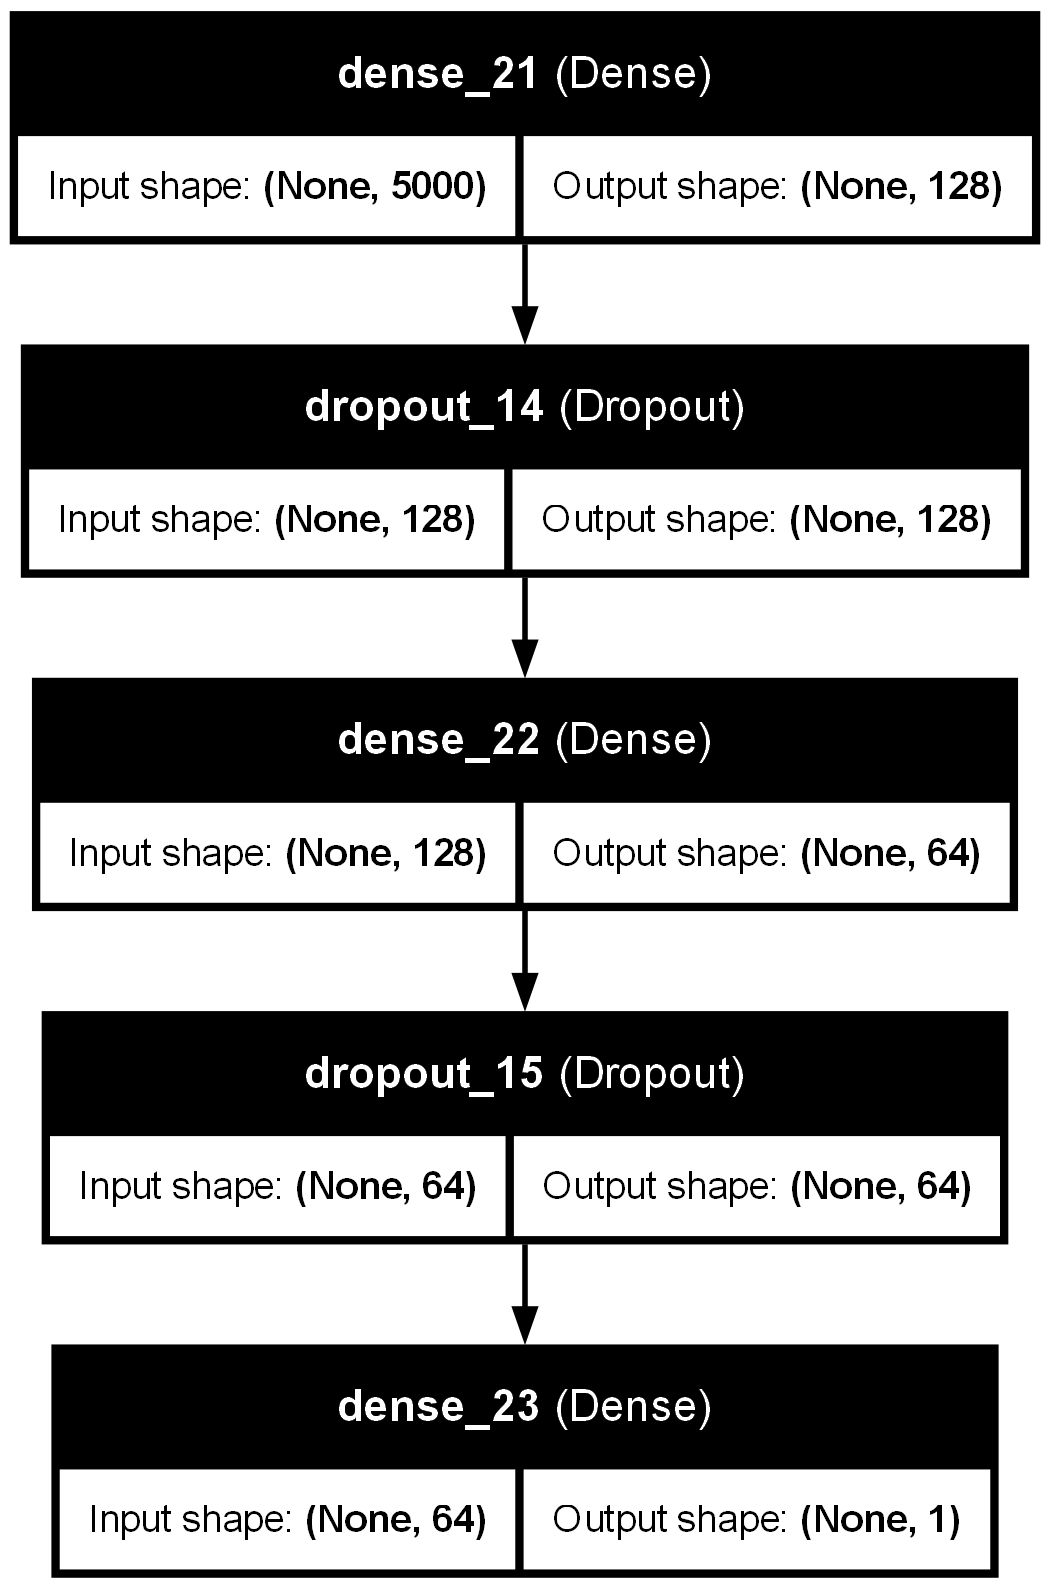

In [ ]:
# !pip3 install pydot
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

y_pred_prob = model.predict(X_test) 
y_pred = (y_pred_prob > 0.5).astype(int)  

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model: Neural network with CountVectorizer")

print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-"*50)
print("Loss Function: ", model.loss[0:7])
print("-"*50)
print("Metrics: ", model.metrics_names)
print("-"*50)
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-"*50)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


plot_model(model, show_shapes=True, show_layer_names=True)

Though high, worth noting is the pre-processing method used. We chose count vectorizer to investigate its effectiveness, However, more modern methods to represent text data have been developed over the years. The next method we will consider is Word2Vec, a word embedding technique. One of its most distinctive feature that sets it apart from count vectoriser is its ability to capture semantic relationships between words, allowing the model to better understand the context and meaning within strings of text.

Furthermore, word embeddings are also usually lower-dimensional and less dense vectors, making them more computationally efficient.

In [15]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

# data = pd.read_csv('processed_data.csv')
second_run = data['processed_full_content']

# documents = second_run.apply(lambda x: x.split())  # Simple whitespace tokenizer
labels = data['label'].values
sentences = [sentence.lower().split() for sentence in second_run]
# Step 2: Train Word2Vec embeddings
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_embedding(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

embeddings = [get_embedding(article) for article in second_run]
X = np.array(embeddings)  
y = labels  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Build the neural network
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=20, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')



Epoch 1/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8461 - loss: 0.9792 - val_accuracy: 0.9051 - val_loss: 0.3063
Epoch 2/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8985 - loss: 0.3151 - val_accuracy: 0.9133 - val_loss: 0.2780
Epoch 3/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0.2941 - val_accuracy: 0.9195 - val_loss: 0.2637
Epoch 4/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9094 - loss: 0.2832 - val_accuracy: 0.9184 - val_loss: 0.2602
Epoch 5/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9115 - loss: 0.2734 - val_accuracy: 0.9245 - val_loss: 0.2486
Epoch 6/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9159 - loss: 0.2670 - val_accuracy: 0.9266 - val_loss: 0.2448
Epoch 7/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.2634 - val_accuracy: 0.9290 - val_loss: 0.2402
Epoch 8/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9200 - loss: 0.2589 - val_accuracy: 0.

400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Model: Neural network with Word2Vec
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_24 regularizer: L2
Layer dense_25 regularizer: L2
--------------------------------------------------
Accuracy: 0.9340745380519887
Precision: 0.9191626957113683
Recall: 0.936373092926491
F1 Score: 0.9276880796976984


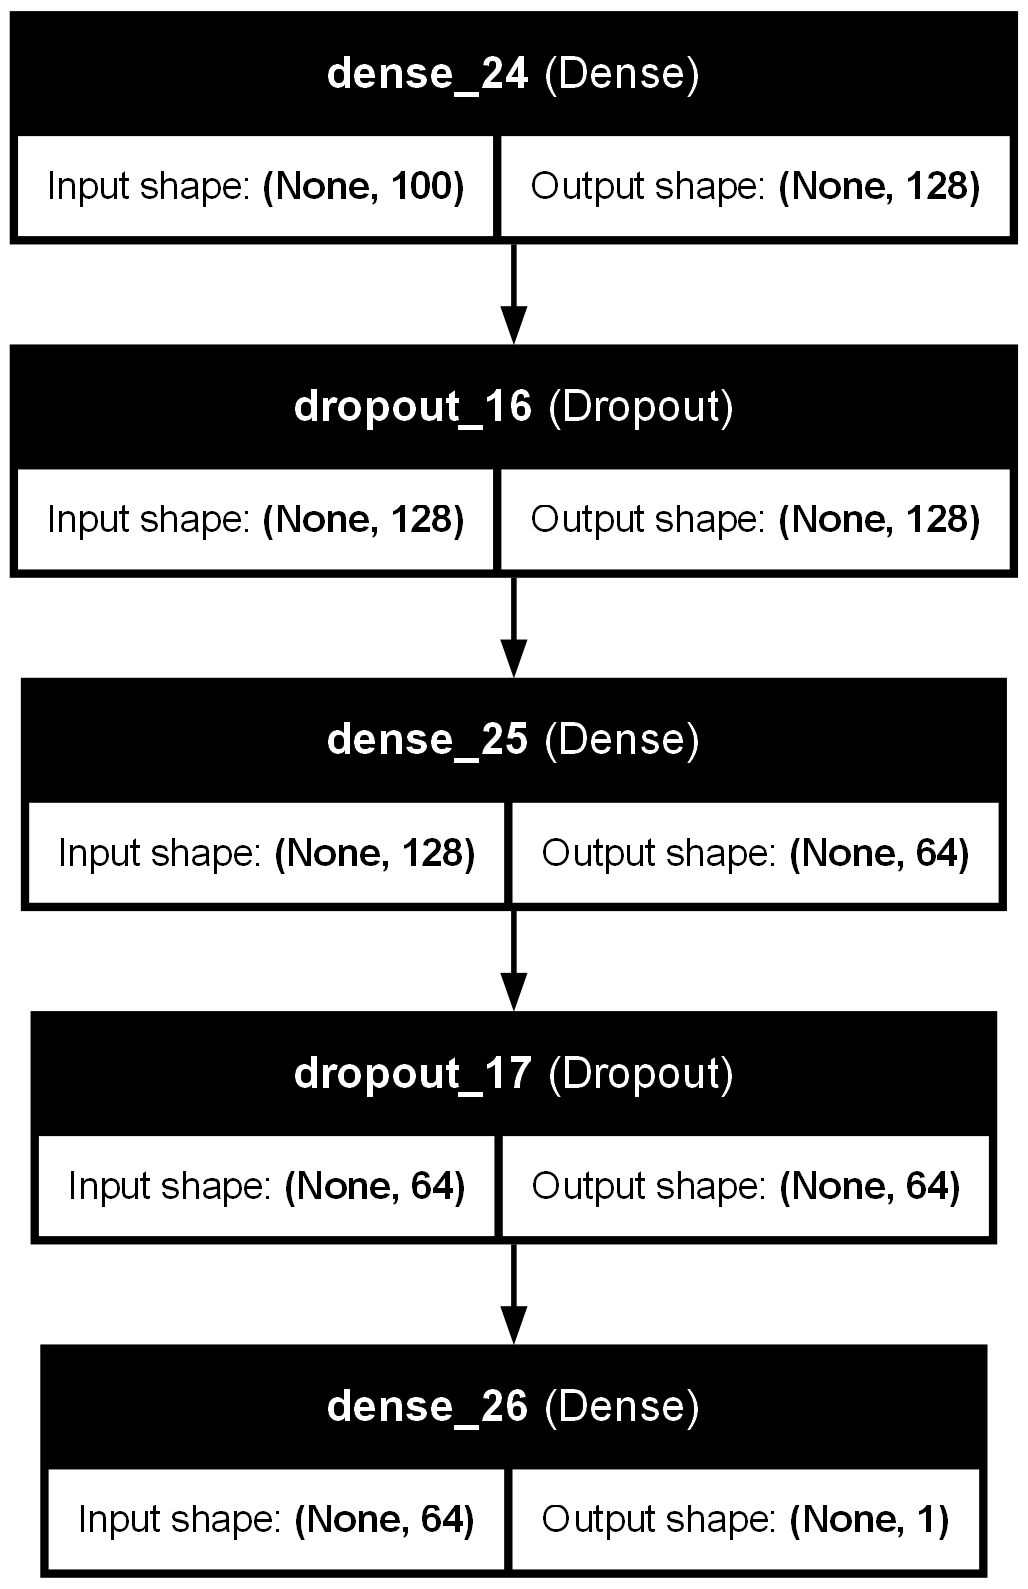

In [16]:
from tensorflow.keras.utils import plot_model

y_pred_prob = model.predict(X_test) 
y_pred = (y_pred_prob > 0.5).astype(int)  

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model: Neural network with Word2Vec")

print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-"*50)
print("Loss Function: ", model.loss[0:7])
print("-"*50)
print("Metrics: ", model.metrics_names)
print("-"*50)
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-"*50)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

plot_model(model, show_shapes=True, show_layer_names=True)

# Using k-fold partitioning to achieve better results

As we have learnt from our experiment with CNN, using count vectorizer/tf-idf will result in the the model being unable to capture language patterns and word associations since each term is treated as an independent vector (thus not being context aware). Subsequently, we will explore the performance of the model when GloVe is used for the pre-processing instead.

Developed after Word2Vec, it works on the idea of using leveraging a global context(across the corpus) rather than merely a local one (i.e. neighbouring words). 
Some advantages over word2vec include: 
- models relationship between words explicitly, allowing for potentially more interpretable semantic relationships
- more stable and efficientapporach that is less sensitive to hyperparameters
- robust across tasks, especially when understanding global context is crucial

Additionally, we will use the same k-fold partitioning method as the CNN experiment.

In [17]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [18]:

data = pd.read_csv('processed_data.csv')
k_fold_var = data['processed_full_content'].copy()

#Parameters used
dropout = 0.3
layer_1 = 128
layer_2 = 64

embeddings_index = {}
with open('./glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs

def text_to_embedding(text, embeddings_index, embedding_dim=100):
    words = text.split()
    embeddings = [embeddings_index[word] for word in words if word in embeddings_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)
    
X_embeddings = np.array([text_to_embedding(text, embeddings_index) for text in k_fold_var])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y = data['label']  

def create_model(input_shape):
    model = Sequential([
        Dense(layer_1, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        Dense(layer_2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Store metrics
acc_scores, prec_scores, recall_scores, f1_scores = [], [], [], []

for train_index, test_index in skf.split(X_embeddings, y):
    X_train, X_test = X_embeddings[train_index], X_embeddings[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(X_embeddings.shape[1])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    # Predictions and Metrics
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))



c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


Stratified K-fold with GloVe
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_39 regularizer: L2
Layer dense_40 regularizer: L2
--------------------------------------------------
Average Accuracy: 0.87161
Average Precision: 0.86268
Average Recall: 0.86125
Average F1 Score: 0.85966


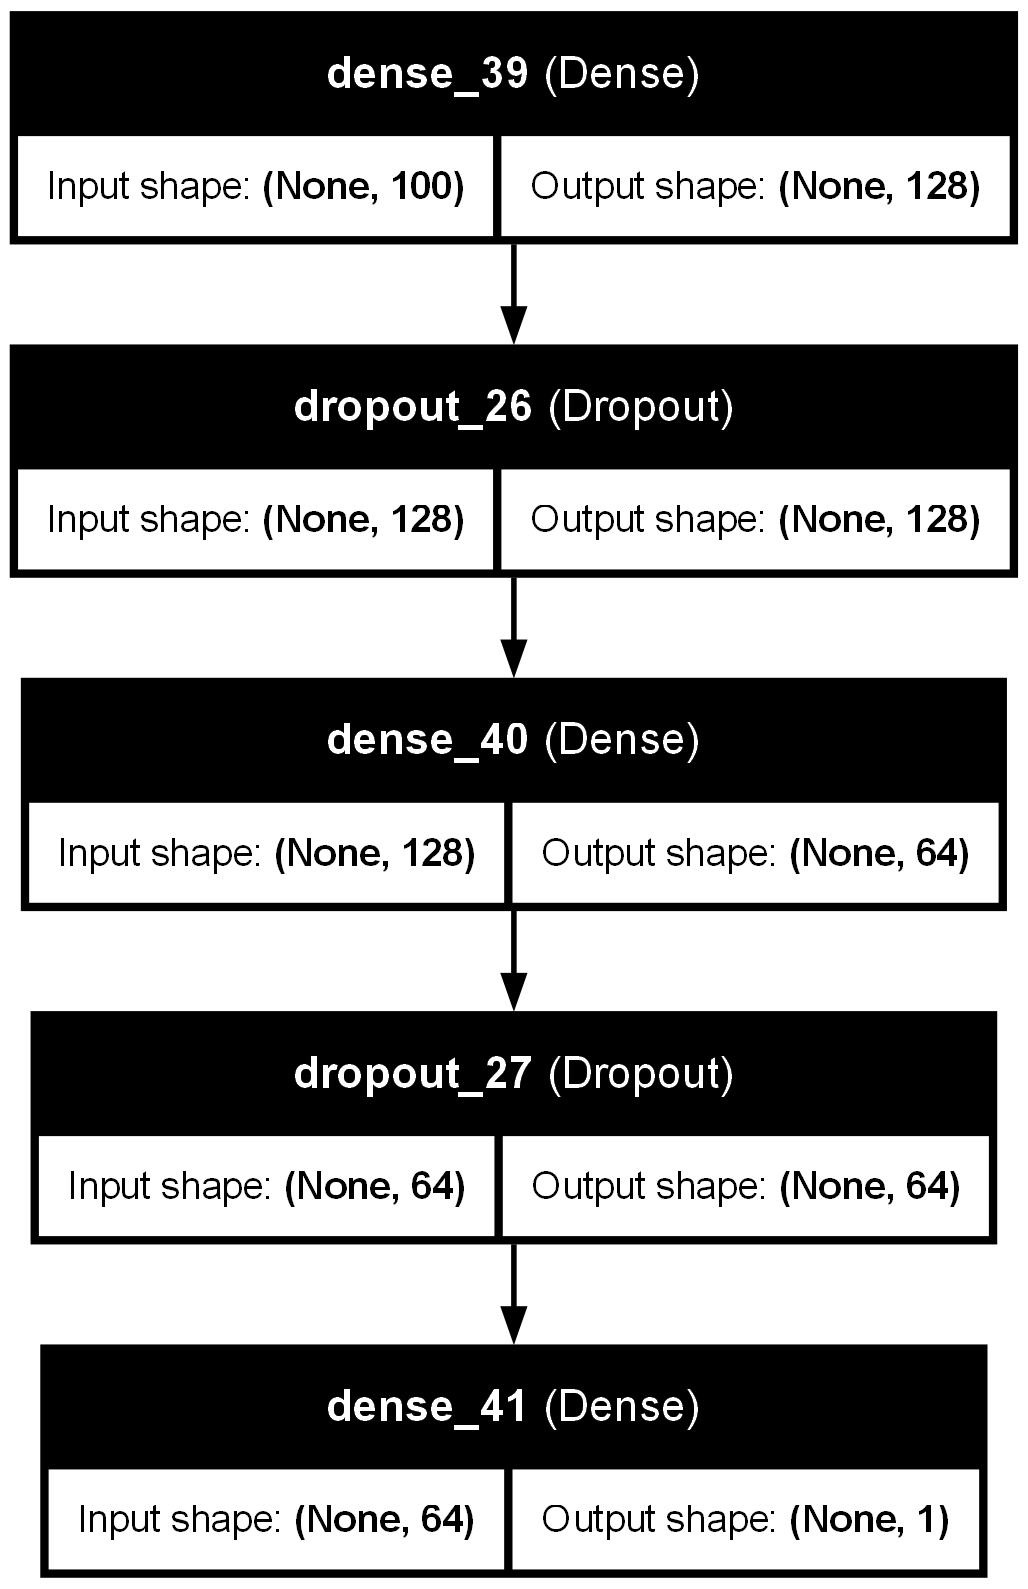

In [19]:
print(f"Stratified K-fold with GloVe")

print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-"*50)
print("Loss Function: ", model.loss[0:7])
print("-"*50)
print("Metrics: ", model.metrics_names)
print("-"*50)
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-"*50)

print(f"Average Accuracy: {np.mean(acc_scores):.5f}")
print(f"Average Precision: {np.mean(prec_scores):.5f}")
print(f"Average Recall: {np.mean(recall_scores):.5f}")
print(f"Average F1 Score: {np.mean(f1_scores):.5f}")


plot_model(model, show_shapes=True, show_layer_names=True)